This notebook is the trains the retail-manufacturer sequence data using a Neural Machine Translation model and the translation is vlaidated with an Information Retrieval system. A major part of the encoder-decoder model has been adapted from Pytorch's chatbot tutorial model to which I have made certain tweaks to make the model feasible for my project.

In [1]:
import numpy as np
import re, itertools, os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
from pandas.io.json import json_normalize
import time
import random, pickle
import nltk
from nltk.corpus import stopwords
import ast
import gensim, collections
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from operator import itemgetter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Some initilisations - please change the file_dir to your working directory to read the file
file_dir = '/home/danyzix/Dissertation/Data'

In [3]:
# pickling functions to save and load lists
def pickle_save(data, name):
    path = os.path.join(file_dir, '{}.pkl'.format(name))
    with open(path, "wb") as f:
        pickle.dump(data, f, protocol=-1)
        f.close()
def pickle_open(name):
    path = os.path.join(file_dir, '{}.pkl'.format(name))
    with open(path, "rb") as f:
        data = pickle.load(f)
        f.close()
    return data

## INSTRUCTIONS:
This notebook is divided into three parts:
1. Data preparation to feed the sequences to the model
2. Model building - building the encoder-decoder model
3. Model training
4. Chosing the best models
5. Sequence generation
6. Evaluation of the generated sequences

It is not necessary to run part 2 to 5 if you are not training the model or generating the sequences. The generated sequences to evaluate have already been provided in the Data folder. If you decide to run them then please be careful to check the file inititalisations. Also the models were trained on a Goole Colab GPUs so make sure to choose the correct initialisition option to load a GPU trained model on CPU. The instructoions are all in the code.

Part 5 could be plotted as the loss files are in the data folder.

Lets start by opening the cleaned retail-brand sequences we saved in the last step.

In [4]:
# open the clean retail-manufacturer sequence pairs
rb_pairs3 = pickle_open('rb_pairs3')

# 1. Data preparation

In the following part of the Data Preparation section, I'll be defining many functions which performs different actions to get the data ready to build a sequence to sequence generation model. Many of the functions have been borrowed from Pytorch's Chatbot tutorial page at https://pytorch.org/tutorials/beginner/chatbot_tutorial.html .

I have modified the Pytorch's Chatbot Tutorial code at many parts to suit my sequence to sequence generation model.

In [5]:
# clean texts: lowercase, trim, de-dup.....
def normalise_text(t):
    # split into tokens by white space
    tokens = t.split()
    # replace a list punctuations with space from each token
    punctuations="""'!"#$%&\'()*,-/:;®™<=>?@[\\]^_`{|}~"""
    table = str.maketrans(punctuations,' '*len(punctuations))
    tokens = [w.translate(table) for w in tokens]
    tokens = [w.lower() for w in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # reduce multiple spaces to one  
    tokens = re.sub(' +', ' ', ' '.join(tokens)).split()
    # remove duplicate tokens preserving the order
    tokens = [i for n,i in enumerate(tokens) if i not in tokens[:n]]
    # join the string to a list
    tokens = ' '.join(tokens)
    return tokens

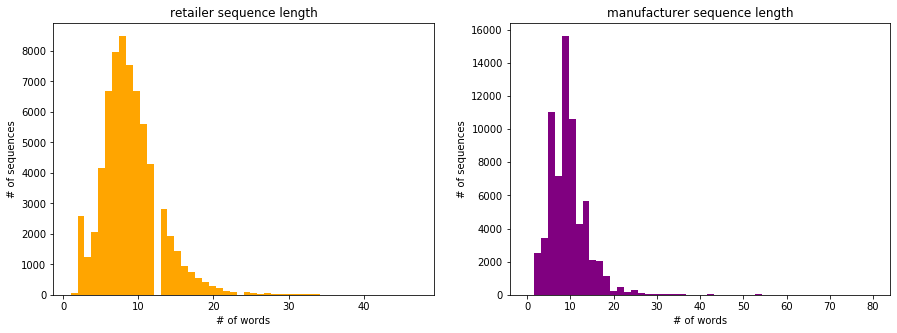

In [6]:
# histogram to see the distribution of word counts in each text pairs
r_text_len = []
for i in range(len(rb_pairs3)):
    r_text_len.append(len(rb_pairs3[i][0].split(' ')))
b_text_len = []
for i in range(len(rb_pairs3)):
    b_text_len.append(len(rb_pairs3[i][1].split(' ')))
    
f, axs = plt.subplots(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(r_text_len, bins=50, color='orange')
plt.title('retailer sequence length')
plt.ylabel('# of sequences')
plt.xlabel('# of words')
plt.subplot(1,2,2)
plt.hist(b_text_len, bins=50, range=[0, 80],color='purple')
plt.title('manufacturer sequence length')
plt.ylabel('# of sequences')
plt.xlabel('# of words')
plt.show()   

We can see that the sequences of brands are longer than the retail and the sequence length can trimmed at 50 words.

In [7]:
# This is the vocabulary which creates three dictionaries word2index, index2word, word2count 
# Counts the total number of words in the dictionary, adds 3 additional tokens in the index2word 
PAD_token = 0  # used for padding short sentences
SOS_token = 1  # start of sentence token
EOS_token = 2  # end of sentence token

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: 'PAD', SOS_token:'SOS', EOS_token: 'EOS'}
        self.num_words = 3  # count SOS, EOS, PAD
        
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
            
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

In [8]:
#  give the vocabulary a name
vocab = Vocabulary('retail-brand')

In [9]:
# function to trim sentences longer than what we decide
MAX_LENGTH = 50

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Now that we've defined a Class for the dictionary and a funtion to trim the sequences, lets generate the vocabulary and then divide the data into three sets: train, validation and test. 

I'll use the train and validation data for training and tuning the model. Once the optimal hyper-parameters are achieved, the model will be trained on the train + validation data and test on the test data.

In [10]:
# Prepare the data
def prepareData(pairs):
    print("Read {} sentence pairs".format(len(pairs)))
    # keep only the retail-brand pairs which both has less word length less than MAX_LENGTH
    pairs = filterPairs(pairs)
    print("Trimmed to {} sentence pairs".format(len(pairs)))
    for pair in pairs:
        vocab.addSentence(pair[0])
        vocab.addSentence(pair[1])
    print("Word counts: {}".format(vocab.num_words))
    return vocab, pairs

I'm adding all the words/tokens in the entire dataset to the vocabulary so that it's easier to build word embeddings during training, validation and testing. Word which are does not exist in the vicabulary will simply be ignored.

In [11]:
# update the two vocabularies, return a rb_pair4 list which has both retail and brand texts in pairs
vocab, rb_pairs4 = prepareData(rb_pairs3)

Read 67457 sentence pairs
Trimmed to 67278 sentence pairs
Word counts: 70550


### Train - Validation - Test Data split : 60:20:20.
I also concatenate the train and validation sets to full train the model once the validation is done.

In [12]:
# Split data into train, validation and test sets
random.seed(5)
rb_pairs5 = random.sample(rb_pairs4, len(rb_pairs4))
train_pairs = rb_pairs5[:int((len(rb_pairs5)+1)*.60)] 
validation_pairs = rb_pairs5[int(len(rb_pairs5)*.60+1):int((len(rb_pairs5)+1)*.80)] 
test_pairs = rb_pairs5[int(len(rb_pairs5)*.80+1):] 
full_train_pairs = train_pairs + validation_pairs

len(train_pairs), len(validation_pairs),  len(test_pairs), len(rb_pairs5)

(40367, 13456, 13455, 67278)

Next two functions are defined to retrieve word index from the dictionary, add a end of sentence token to each sequence and add a 0 padding to shorter sequences.

In [13]:
# function to obtain word index for each word in a sentence and add the EOS_token at the end of the sentence.
# Please note that words not in the vocab will simply be ignored
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ') if word in voc.word2index.keys()] + [EOS_token]

# padding function - padds 0 at the end of each list till the maximum length of sentences and creates a transpose of the data
def zeroPadding(l, fillvalue=0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [14]:
# lets try the two functions above
inp = []
for pair in rb_pairs5[56:58]:
    inp.append(pair[0])
indexes = [indexesFromSentence(vocab, sentence) for sentence in inp]
print(inp[0])
print(indexes[0])
print(inp[1])
print(indexes[1])

lg 50pg30 50 high definition 1080p plasma tv
[153, 49553, 481, 493, 29858, 527, 14278, 162, 2]
samsung 343l top mount fridge stainless steel
[3, 34332, 6588, 760, 26, 202, 30, 2]


In [15]:
test = zeroPadding(indexes)
print(len(test))
test

9


[(153, 3),
 (49553, 34332),
 (481, 6588),
 (493, 760),
 (29858, 26),
 (527, 202),
 (14278, 30),
 (162, 2),
 (2, 0)]

In [16]:
# A binary function which will be later used to mask the paded indexes
# It assigns a 0 to each of the 0 padded indexes
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [17]:
binary_result = binaryMatrix(test)
binary_result

[[1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 0]]

Next is a couple of functions to gentrate a batch of sequences for training. The following steps are performed:
1. word indexes are retrieved from the vocabulary for the input and target sequences
2. sequences shorter than the longest sequence in the batch for both input and target are padded with 0
4. a tensor which has the sequence length for each sequences in each of the input and target batches is generated 
5. a mask tensor is used to mask the padded parts of the target sequence

In [18]:
# returns padded input sequence tensor and a tensor of lengths for each of the sequences in the batch
def inputVar(list, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in list]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)  # transpose the list and pads zero
    padvar = torch.LongTensor(padList)
    return padvar, lengths

# returns padded target sequence tensor, padding mask, and max length target
def outputVar(list, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in list]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)   # transpose the list and pads zero
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)          # generate the mask tensor, only for output sequence
    padvar = torch.LongTensor(padList)
    return padvar, mask, max_target_len

# returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    # sort the pairs only by the descending length of the input sequence
    pair_batch.sort(key=lambda x: len(x[0].split(' ')), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    # assert len(inp) == lengths[0]
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

In [19]:
# example for validation
small_batch_size = 3
batches = batch2TrainData(vocab, [random.choice(rb_pairs5) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print('input_sequence:', input_variable)
print('input sequence lengths:', lengths)
print('target_sequence:', target_variable)
print('mask:', mask)
print('max_target_len:', max_target_len)

input_sequence: tensor([[ 1485,   331,   199],
        [ 1081,  4301,  1720],
        [ 2074,  4302, 59830],
        [  158,  1358, 58842],
        [  306,  1359,  8840],
        [  416,   548,   306],
        [   63,  1360,   392],
        [ 2075,   694, 65983],
        [  344,   695,     2],
        [  415,     2,     0],
        [35241,     0,     0],
        [    2,     0,     0]])
input sequence lengths: tensor([12, 10,  9])
target_sequence: tensor([[ 1485,   331,   199],
        [ 1081,    99, 34282],
        [ 2074,  4301,   306],
        [  158,  4302,   392],
        [  306,  1358, 21522],
        [ 3694,  1359,  1720],
        [  799,   548, 59830],
        [  798,  8523,  8840],
        [ 1244,     2, 64047],
        [47100,     0,     2],
        [47101,     0,     0],
        [47102,     0,     0],
        [47103,     0,     0],
        [47104,     0,     0],
        [    2,     0,     0]])
mask: tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
 

# 2. Building the model

The Encoder is built using bidirectional GRUs. Each batch of the encoder returns a final hidden state and the respective outputs of each of the GRUs. Number of GRUs per batch is auto generated based on the number of timesteps which is dependent on the maximum sequence length in each batch.

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()  # super is method of inheriting all of parent's class which is the nn.Module class
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding
        # initialize the GRU; the input_size and hidden_size params are both set to 'hidden_size'
        # because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout), bidirectional=True)
    
    def forward(self, input_seq, input_lengths, hidden=None):
        # input_seq: batch of input sentences; shape=(max_length, batch_size)
        # input_lengths: list of sentence lengths corresponding to each sentence in the batch
        # hidden state of shape: {n_layers x num_directions, batch_size, hidden_size}
        embedded = self.embedding(input_seq)  # convert word indexes to embeddings
        # pack padded batch of sequences for RNN module: input_seq shape transformation (batch_size, max_length)
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # forward pass through GPU
        outputs, hidden = self.gru(packed, hidden)
        # unpack padding
        outputs, _ = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        # sum bidirectional GRU outputs
        outputs = outputs[:,:,:self.hidden_size] + outputs[:,:,self.hidden_size:]
        # return output and final hidden state
        return outputs, hidden
        # outputs: the output features h_t from the last layer of the GRU, for each timestep (sum of bidirectional outputs)
        # outputs: shape-(max_length, batch_size, hidden_size)
        # hidden: hidden state for the last timestep, of shape-(n_layers x num_directions, batch_size, hidden_size)

Attention mechanism in the decoder uses a dot product between encoder output and decoder output.

In [21]:
# Luang attention layer
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
    def dot_score(self, hidden, encoder_output):
        # element-wise multiply the current target decoder state with the encoder output and sum them
        return torch.sum(hidden * encoder_output, dim=2)
    
    
    def forward(self, hidden, encoder_outputs):
        # hidden of shape: (1, batch_size, hidden_size)
        # encoder_outputs of shape: (max_length, batch_size, hidden_size)
        # (1, batch_size, hidden_size) * (max_length, batch_size, hidden_size) = (max_length, batch_size, hidden_size)
                
        # calculate the attention weights (energies)
        # sum across the hidden_size with dim=2 in dot_score function
        attn_energies = self.dot_score(hidden, encoder_outputs)   # (max_length, batch_size)
        # transpose max_length and batch_size dimensions as we want to get a softmax of each batch
        attn_energies = attn_energies.t()                         # (batch_size, max_length)
        # return the softmax normalizes probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)       # (batch_size, 1, max_length)     

The Decoder returns a softmax normalized tensor giving probabilities of each word being the correct next word in the decoded sequence.

In [22]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropuot = dropout
        
        # define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers==1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)
        
    def forward(self, input_step, last_hidden, encoder_outputs):
        # input step: one time step (one word) of input sequence batch; shape=(1, batch_size)
        # last_hidden: final hidden state of encoder GRU; shape=(n_layers x num_directions, batch_size, hidden_size)
        # encoder_outputs: encoder model's output; shape=(max_length, batch_size, hidden_size)
        # note: we run this one step (batch of words) at a time
        # get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # rnn_output of shape: (1, batch, num_directions * hidden_size)
        # hidden of shape: (num_layers * num_directions, batch, hidden_size)
        
        # calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # multiply attention weights to encoder outputs to get new 'weighted sum' context vector
        # (batch_size, 1, max_length) bmm (batch multiply-matrix multiplication) with (batch_size, max_length, hidden) 
        # = (batch_size, 1, hidden)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # concatenate weighted context vector and GRU unit
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))  # shape: (batch_size, hidden_size)
        # predict next word using Luong eq. 6
        output = self.out(concat_output)  # shape: (batch_size, vocab_size)
        output = F.softmax(output, dim=1)
        # return output and final hidden state
        return output, hidden
        # output: softmax normalized tensor giving probabilities of each word being the correct next word in the decoded sequence
        # shape = (batch_size, vocab.num_words)
        # hidden: final hidden state of GRU; shape=(n_layers x num_directions, batch_size, hidden_size)

Taken from Pytotch documentation....

Loss function:
Since we are dealing with batches of padded sequences, we cannot simply consider all elements of the tensor when calculating loss. We define maskNLLLoss to calculate our loss based on our decoder’s output tensor, the target tensor, and a binary mask tensor describing the padding of the target tensor. This loss function calculates the average negative log likelihood of the elements that correspond to a 1 in the mask tensor.

In [23]:
def maskNLLLoss(decoder_out, target, mask):
    nTotal = mask.sum()  # how many elements should we consider
    target = target.view(-1, 1)
    # decoder_out shape: (batch_size, vocab_size), target_size: (batch_size, 1)
    gathered_tensor = torch.gather(decoder_out, 1, target)  # gather the two tensors together
    # calculate Negative Log Likelihood loss
    crossEntropy = -torch.log(gathered_tensor)
    loss = crossEntropy.masked_select(mask)
    # calculate the mean of the loss
    loss = loss.mean()
    loss = loss.to(device)
    return loss, nTotal.item()

# 3. Model Training

Training uses Teacher Forcing.... but could be disabled changing teacher_forcing_ratio value later

In [24]:
def train(pairs, input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero out the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration based on teacher_forcing_ratio
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)  # selects the index with the highest softmax, shape(batch_size, 1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    if pairs == train_pairs:
        loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [25]:
def trainIters(model_name, voc, train_pairs, validation_pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, 
               encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every,
               clip, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(train_pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]
    validation_batches = [batch2TrainData(voc, [random.choice(validation_pairs) for _ in range(batch_size)])
                          for _ in range(n_iteration)]
    # Initializations
    print('Initializing ...')
    loss_list = []
    start_iteration = 1
    print_train_loss = 0
    print_validation_loss = 0
    
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1
      
    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        
        # encoder and decoder set to train mode before training
        encoder.train()
        decoder.train()
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        train_loss = train(train_pairs, input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_train_loss += train_loss
    
        # set encoder and decoder to eval mode for validation
        encoder.eval()
        decoder.eval()
        validation_batch = validation_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = validation_batch

        # Run a training iteration with batch
        validation_loss = train(validation_pairs, input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_validation_loss += validation_loss
               

        # Print progress
        if iteration % print_every == 0:
            print_loss_train_avg = print_train_loss / print_every
            print_loss_validation_avg = print_validation_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average train loss: {:.4f};  Average validation loss: {:.4f}".format(iteration, iteration / n_iteration * 100,
                                                                                                                                  print_loss_train_avg, print_loss_validation_avg))
            loss_list.append([iteration, print_loss_train_avg, print_loss_validation_avg])
            print_train_loss = 0
            print_validation_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):   
            directory = os.path.join(save_dir, model_name,'{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'validation_loss': validation_loss,
                'train_loss' : train_loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}_{}.tar'.format(iteration, 'checkpoint', batch_size)))
    return loss_list

Here is the part to choose training parameters of the model.  
Please note, if the pre-saved model needs to be loaded then the filename structure should help in indentifying which models to load, e.g. 6000_checkpoint_32.tar saved in the 2-2_500 folder is a model trained with 6000 iterations, 32 batch_size, encoder_n_layers=2, decoder_n_layers=2, hidden_size=500.
Based on such combinations, the model parameters can be updated to load the models below

In [26]:
# Configure models           
model_name = 'seq_model'
save_dir = file_dir
attn_model = 'dot'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.5
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
#loadFilename = None
checkpoint_iter = 6000 
loadFilename = os.path.join(save_dir, model_name,
                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                            '{}_checkpoint_{}.tar'.format(checkpoint_iter, batch_size))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    #checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    vocab.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(vocab.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, vocab.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


The following block of code is to be used only for training

In [27]:
# Configure training/optimization
start = time.process_time()
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 100
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# Run training iterations
print("Starting Training!")
loss_train = trainIters(model_name, vocab, train_pairs, validation_pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
               embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
               print_every, save_every, clip, loadFilename)

# save the average loss
pickle_save(loss_train,'loss_{}_{}_{}_{}'.format(batch_size, hidden_size, encoder_n_layers, decoder_n_layers))
print(time.process_time() - start)

Building optimizers ...
Starting Training!
Initializing ...
Training...
19.765625


# 4. Chosing the best model

In [28]:
# open the files which has the training and validation losses
loss_32_300_2_2 = pickle_open('loss_32_300_2_2')
loss_32_500_2_2 = pickle_open('loss_32_500_2_2')
loss_64_500_2_2 = pickle_open('loss_64_500_2_2')
loss_128_500_2_2 = pickle_open('loss_128_500_2_2')
loss_64_500_3_3 = pickle_open('loss_64_500_3_3')
loss_64_500_4_4 = pickle_open('loss_64_500_4_4')

In [29]:
# function to plot them together
def train_val_loss(loss_file, model_name):
    train_loss = [a[1] for a in loss_file]
    val_loss = [a[2] for a in loss_file]
    mini_iter = [a[0] for a in loss_file]
    plt.plot(mini_iter, train_loss, label = 'train_loss')
    plt.plot(mini_iter, val_loss, label = 'validation_loss')
    # plt.xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.legend(loc='upper right')
    plt.title('{}'.format(model_name), fontsize=10)   #fontweight='bold'
    # plt.suptitle('{}'.format(model_name), fontsize=10)
    plt.xlabel("# of mini-iterations")
    plt.ylabel("Average loss")
    plt.tight_layout()

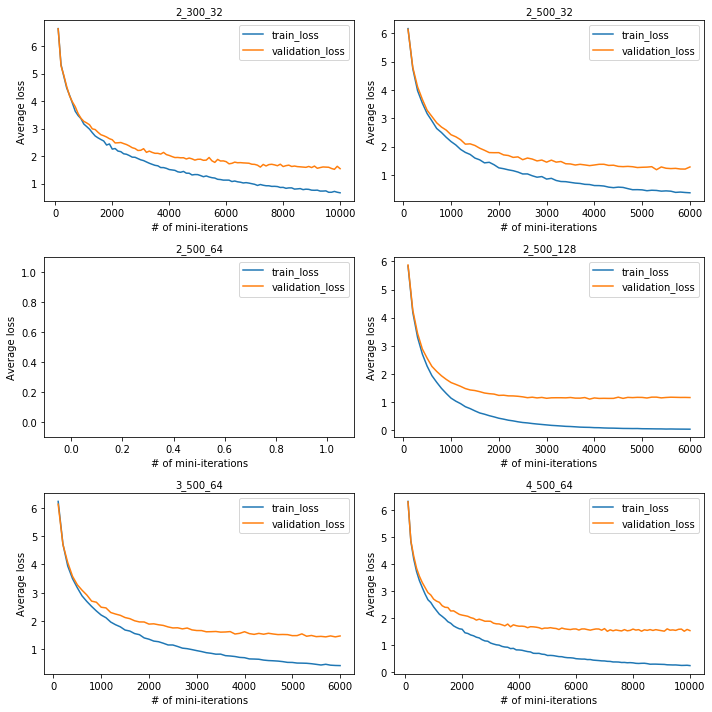

In [64]:
# now the plots
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
train_val_loss(loss_32_300_2_2, '2_300_32')
plt.subplot(3,2,2)
train_val_loss(loss_32_500_2_2, '2_500_32')
plt.subplot(3,2,3)
train_val_loss(loss_64_500_2_2, '2_500_64')
plt.subplot(3,2,4)
train_val_loss(loss_128_500_2_2, '2_500_128')
plt.subplot(3,2,5)
train_val_loss(loss_64_500_3_3, '3_500_64')
plt.subplot(3,2,6)
train_val_loss(loss_64_500_4_4, '4_500_64')

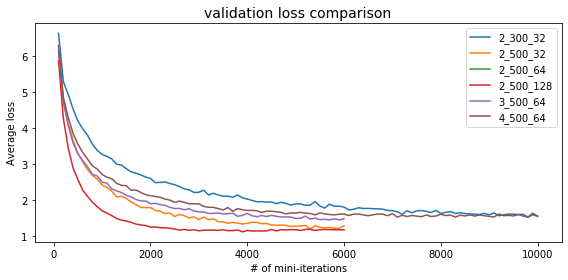

In [31]:
# comparison of all variation losses 
plt.figure(figsize=(8,4))
plt.plot([a[0] for a in loss_32_300_2_2], [a[2] for a in loss_32_300_2_2], label = '2_300_32')
plt.plot([a[0] for a in loss_32_500_2_2], [a[2] for a in loss_32_500_2_2], label = '2_500_32')
plt.plot([a[0] for a in loss_64_500_2_2], [a[2] for a in loss_64_500_2_2], label = '2_500_64')
plt.plot([a[0] for a in loss_128_500_2_2], [a[2] for a in loss_128_500_2_2], label = '2_500_128')
plt.plot([a[0] for a in loss_64_500_3_3], [a[2] for a in loss_64_500_3_3], label = '3_500_64')
plt.plot([a[0] for a in loss_64_500_4_4], [a[2] for a in loss_64_500_4_4], label = '4_500_64')
plt.legend(loc='upper right')
plt.title('validation loss comparison', fontsize=14)   #fontweight='bold'
plt.xlabel("# of mini-iterations")
plt.ylabel("Average loss")
plt.tight_layout()

# 5. Sequence generation

This is the section which generates output sequence based on the trained models above. It should be used to generate sequences from the validation and test data. Most of the functions have been borrowed from Pytorch's Chatbot tutorial page at https://pytorch.org/tutorials/beginner/chatbot_tutorial.html to which I've made some changes.


Greedy decoding is the decoding method that we use during training when we are NOT using teacher forcing. In other words, for each time step, we simply choose the word from decoder_output with the highest softmax value. This decoding method is optimal on a single time-step level.

In [32]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [33]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words

def evaluateInput(encoder, decoder, searcher, voc, sentence):
    # Normalize sentence
    sentence = normalise_text(sentence)
    sentence = [a for a in sentence.split() if a in vocab.word2index.keys()]
    sentence = ' '.join(sentence)
    # Evaluate sentence
    output_words = evaluate(encoder, decoder, searcher, voc, sentence)
    # Format and print response sentence
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    output_words = ' '.join(output_words)
    return(output_words)

In [34]:
# Set dropout layers to eval mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

In [35]:
# function to generate the output sequences
def predict(pairs):
    # get the ouput sequences for each retail text and append the right sequence
    start = time.time()
    predictions=[]
    for i in range(len(pairs)):
        output = evaluateInput(encoder, decoder, searcher, vocab, pairs[i][0])
        predictions.append([output, pairs[i][1]])
        if i%500 == 0:
          print('processed {} pairs in {}'.format(i+1, time.time()-start))
    print('finished predicting')
    return predictions

### Time to start generating the sequences from the trained model.

In [38]:
# choose which data set to use for sequence generation
# it should be either 'test' or 'validation' to choose the righ dataset
mode = 'test'
pairs = train_pairs if mode == 'train' else validation_pairs if mode == 'validation' else test_pairs if mode == 'test' else full_train_pairs
len(pairs)

# start generaing the predicted sequences......
predictions = predict(pairs)

# save the predictions - give a new name.....
pickle_save(predictions, 'predictions_{}_{}_{}_{}_{}'.format(mode, batch_size, hidden_size, encoder_n_layers, decoder_n_layers))

# 6. EVALUATION


The evaluation process will test the quality of the sequences generated by the above model. In this project I'll be using two techniques for the evaluation process. In both the methods, I'll be comparing cosine similarity of each of the generated sequences with each of the brand brand-text sequence and test if the brand-text sequence with the highest score has the same product_id as the initial input retail-brand mapping product_id.

1. TFIDF method
2. Doc2Vec method

In [36]:
# function to get unique texts and update a Counter from a list
def get_unique_texts(data, row):
    temp_text = []
    for i in range(len(data)):
        temp_text.append(data[i][row])
    counter = collections.Counter(temp_text)               # add a counter to count the frequency of texts in the brand texts
    unique_text = list(set(temp_text))                     # form a set of unique texts for the data
    return counter, unique_text  

### Choose the dataset to evaluate. 

In [38]:
mode = input("Choose a dataset to evaluate from -- validation / test")
print('datset chosen: {}'.format(mode))

Choose a dataset to evaluate from -- validation / testtest
datset chosen: test


In [39]:
# assign the right dataset to evaluate
evaluation_pairs = train_pairs if mode == 'train' else validation_pairs if mode == 'validation' \
                    else test_pairs if mode == 'test' else print('choose wrong data chosen')
print('row in evaluation_pairs: {}'.format(len(evaluation_pairs)))

row in evaluation_pairs: 13455


### Load the pre-genrated sequences from the models.
It's important to load the right file depending on the dataset of evaluation mode chosen above.
The generated sequence files are all in the Data folder and they start with the name 'predictions_'
1. Validation data evaluation --> only sequences with the 'validation' in name
2. Test data evaluation --> only sequences with the 'test' in name

In [40]:
# open the generated sequences file to evaluate
prediction_pairs = pickle_open('predictions_test_64_500_3_3')

# get the unique texts from the predictions
prediction_counter, unique_predictions = get_unique_texts(prediction_pairs, 0)

print('{} generated sequences have only {} unique sequences'.format(len(prediction_pairs), len(unique_predictions)))

13455 generated sequences have only 9753 unique sequences


In [41]:
# open the unique_brand_text_product_mapping file 
# this the manfacturer sequence-productID mapping file that I saved in the Data Preparation notbook
text_product_map = pickle_open('unique_brand_text_product_mapping')
len(text_product_map), text_product_map[1]

(24645,
 ['lg electronics 32 class qhd led ips monitor radeon freesync 31.5 diagonal 32qk500w',
  1531971])

In [42]:
# Lets look at some generated sequencesompare it to the training pairs
for i in range(0,5):
    j = random.randint(0,len(evaluation_pairs))
    print('retailer_seqeunce :{}'.format(evaluation_pairs[j][0]))
    print('manufacturer_seqeunce :{}'.format(evaluation_pairs[j][1]))
    print('generated_seqeunce :{}'.format(prediction_pairs[j][0]))
    print('product id : {}'.format(evaluation_pairs[j][2]))
    print('-----------------------------------------------------')

retailer_seqeunce :sandisk extreme pro 64gb compact flash 160mb s udma 7
manufacturer_seqeunce :sandisk extreme pro sup nbsp compactflash card 64gb sdcfxps064ga46 sdcfxps064gxq46 sdcfxps064gffp sdcfxps064gj92 sdcfxps064gz46 sdcfxps064gx46 sdcfxps064gx46t
generated_seqeunce :sandisk extreme pro sup nbsp compactflash card 64gb sdcfxps064gx46t sdcfxps064gx46 sdcfxps064gffp sdcfxps064gz46 sdcfxps064gj92 sdcfxps064ga46 sdcfxps064gxq46
product id : 807012
-----------------------------------------------------
retailer_seqeunce :philips accessory sh50
manufacturer_seqeunce :philips shaver series 5000 shaving heads sh50 51 multiprecision blades fits s5000 s5xxx aquatouch s6000 s6xxx sh5051
generated_seqeunce :philips shaver diamondclean 3000 كهربائية بدون bg2024 2000 2000
product id : 943820
-----------------------------------------------------
retailer_seqeunce :bosch serie 4 vario style kgn36ij3ag 60 40 fridge freezer pearl night blue
manufacturer_seqeunce :bosch kgn36ij3ag
generated_seqeunce

In [43]:
# form an evaluation corpus from unique_predictions + texts from text_product_map
# only unique seqeunces from the generated file and manufacturer product sequences are used to form the evaluation corpus
eval_corpus = unique_predictions.copy()
for i in range(len(text_product_map)):
    eval_corpus.append(text_product_map[i][0])
    
# verify the data
len(unique_predictions), len(text_product_map), len(eval_corpus)

(9753, 24645, 34398)

# TF-IDF Evaluation

This is the first part of the evaluation process. It does the following actions.
1. Creates a TFIDF_Box which stores all the necessary information which with top 4 similary manufactuerer sequences based ranked cosine similairty index. The number of similar sequences returned could be changed.
2. Next the accuracy of the evaluated data is calculated by comparing if the top ranked similar sequence has the same productID as the initial retail-manufaturer sequence.
3. An information Retreivel system is designed to return the top 4 manufacturer sequnece along with their productIDs and cosine simlarity scores

In [47]:
# TFIDF_Box to store all cosine similarity scores of the prediction vs brand_texts
def TFIDF_Box(corpus):
    tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1,3), min_df = 0)
    tfidf_matrix =  tfidf_vectorizer.fit_transform(corpus)
    # build the box to store all TF-IDF cosine similarity values
    start = time.time()
    print('number of rows to be processed: {}'.format(len(unique_predictions)))
    TFIDF_box = []
    for i in range(len(unique_predictions)):
        cosine_similarities = linear_kernel(tfidf_matrix[i], tfidf_matrix[len(unique_predictions):]).flatten()
        related_docs_indices = cosine_similarities.argsort()[:-5:-1]
        related_products = [text_product_map[a][1] for a in related_docs_indices]
        cosine_similarities = cosine_similarities[related_docs_indices]
        TFIDF_box.append([unique_predictions[i], related_products, cosine_similarities, related_docs_indices ])
        if i%5000==0:
            print('processed {} products, time elapsed:{} seconds'.format(i+1, (time.time() - start)))
    print('complete')
    return TFIDF_box

In [48]:
# calculate accuracy and store correct and wrong predictions
def accuracy_calcluator(model_box, pred_pairs, lookup_pairs):
    n_correct_predictions = 0
    correct_predictions = []
    wrong_predictions = []
    for i in range(len(pred_pairs)):
        predicted_product = [a[1][0] for a in model_box if a[0] == pred_pairs[i][0]][0]
        if predicted_product == lookup_pairs[i][2]:            
            correct_predictions.append([i, lookup_pairs[i][0], lookup_pairs[i][1],
                                        pred_pairs[i][0], predicted_product, lookup_pairs[i][2]])
        else:
            wrong_predictions.append([i, lookup_pairs[i][0], lookup_pairs[i][1],
                                        pred_pairs[i][0], predicted_product, lookup_pairs[i][2]])
            
    return correct_predictions, wrong_predictions

In [49]:
# build the TFIDF_box to store all the cosine similarity values of the top 4 similar seqeunces
# It returns the productID, cosine similarity scores and their row numbers in the manufacteurer product table
TFIDF_box = TFIDF_Box(eval_corpus)

number of rows to be processed: 9753
processed 1 products, time elapsed:0.40305185317993164 seconds
processed 5001 products, time elapsed:630.5725195407867 seconds
complete


In [51]:
# lets look at the contents of one item in the TFIDF_box
TFIDF_box[0]

['beko american style fridge freezer neofrost cooling technology rasfle72px',
 [1443617, 972077, 1288722, 886205],
 array([1.        , 0.82029098, 0.77060631, 0.52628345]),
 array([ 5480, 22460, 12678, 14152])]

### This is where accuracy is calculated

In [52]:
# separate the right and wrong predictions for the prediction and calculate the accuracy
tfidf_overall_CP, tfidf_overall_WP = accuracy_calcluator(TFIDF_box, prediction_pairs, evaluation_pairs)
print('accuracy: {0:.2f}%'.format(int(len(tfidf_overall_CP))/int(len(prediction_pairs))*100))

accuracy: 31.97%


## The Information Retrieval system

In [53]:
# information retrieval - retrieves the most relevant products based on a text search
# It returns 4 sequences but can be customised. 
# Each matched sequence is returned with its productID and cosine similarity score
def retrieve_product(model_box, result, index, number=4):
    # print('input pairs index: {}'.format(result[index][0]))
    print('retailer sequence: {}'.format(result[index][1]))
    print('manufacturer sequence : {}, {}'.format(result[index][2],result[index][5]))
    print('generated sequence: {}'.format(result[index][3]))
    temp_list = [a for a in model_box if a[0] == result[index][3]]
    print('matched products:')
    for i in range(number):
        product = text_product_map[temp_list[0][3][i]]
        cosine_score = round(temp_list[0][2][i],4)
        print('{}: {}'.format(product, cosine_score))

In [54]:
# lets test the Information Retieval system, use tfidf_overall_WP for wrong mapping 
# and tfidf_overall_CP for correct mapping
for i in range(0,5):
    j = random.randint(0,len(tfidf_overall_WP))
    retrieve_product(TFIDF_box, tfidf_overall_WP, j, 4)
    print('----------------------------------------------')

retailer sequence: lego juniors 10755 zane s ninja boat pursuit
manufacturer sequence : lego zane s ninja boat pursuit lego10755 b075gm3lcr, 1312414
generated sequence: lego ip 2018 2 b0765ctsl3 truck
matched products:
['lego ip 2018 3 b0765ctsl3 lego10758', 1349458]: 0.7355
['lego new ip 3 lego10761 b0765ctsl4', 1349457]: 0.5163
['lego ip 2018 2 b07658q3j4 lego10757', 1349452]: 0.4833
['lego ip 2018 2 lego75927 b0765bd4k1', 1362337]: 0.4711
----------------------------------------------
retailer sequence: sandisk 64gb ultra usb type c flash drive speed 150mb s sdcz450 064g g46
manufacturer sequence : sandisk ultra sup usb type c flash drive 64gb sdcz450064gg46, 1095774
generated sequence: sandisk ultra sup dual drive usb type c 64gb sdddc2064gg46
matched products:
['sandisk ultra sup dual drive usb type c 64gb sdddc2064gg46', 1120385]: 1.0
['sandisk ultra dual drive usb type c 64 gb sdddc2064ga46', 1180610]: 0.8616
['sandisk ultra sup dual drive usb type c 16gb sdddc2016gg46', 1120387

# Doc2Vec evaluation

This is the second part of the evaluation process. It does the following actions.
1. It first forms a tagged document from the evaluation corpus.
2. A document embedding neural network model is run to generate the document embeddings.
1. Creates a Doc2Vec_Box which stores all the necessary information which with top 4 similary manufacturer sequences based ranked cosine similairty index. The number of similar sequences returned could be changed.
2. Next the accuracy of the evaluated data is calculated by comparing if the top ranked similar sequence has the same productID as the initial retail-manufaturer sequence.
3. An information Retreivel system is designed to return the top 4 manufacturer sequnece along with their productIDs and cosine simlarity scores

In [55]:
# Create the tagged document needed for Doc2Vec training
def create_tagged_document(list):
    for i, n in enumerate(list):
        yield TaggedDocument(n.split(), [i])

In [56]:
#lets create the Doc2Vec corpus and see how it looks like 
doc2vec_corpus = list(create_tagged_document(eval_corpus))
doc2vec_corpus[:2]

[TaggedDocument(words=['beko', 'american', 'style', 'fridge', 'freezer', 'neofrost', 'cooling', 'technology', 'rasfle72px'], tags=[0]),
 TaggedDocument(words=['samsung', 'galaxy', 'ace', 'smn950fzkabtu'], tags=[1])]

### This is the heart of the process where a deep neural network is trained to generate the document embeddings. The hyperparameters used for training are vector_size and epochs.

In [57]:
# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=300, epochs=1000)

# Build the Volabulary
model.build_vocab(doc2vec_corpus)

# Train the Doc2Vec model
%time model.train(doc2vec_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 1h 11min 51s, sys: 26min 20s, total: 1h 38min 11s
Wall time: 1h 4min 7s


In [60]:
# magic box to store all important information for Doc2Vec cosine similarity calculation
def Doc2Vec_evaluator(corpus, model_docvecs ):
    start = time.time()
    # transform the model.docvecs matrix to a shape which can be used to calculare cosine similarity for the whole array at once
    model_docvecs_flipped =  []
    for i in range(len(model_docvecs)):
        model_docvecs_flipped.append(model_docvecs[i].reshape(1,-1))
    model_docvecs_flip = np.squeeze(model_docvecs_flipped, axis = 1)
    # start populating the Doc2Vec box
    Doc2Vec_box = []                               
    for i in range(len(unique_predictions)):
        cosine_similarities = cosine_similarity(model_docvecs_flip[i].reshape(1,-1), model_docvecs_flip[len(unique_predictions):]).flatten()
        related_docs_indices = cosine_similarities.argsort()[:-5:-1]
        related_products = [text_product_map[a][1] for a in related_docs_indices]
        cosine_similarities = cosine_similarities[related_docs_indices]
        Doc2Vec_box.append([unique_predictions[i],related_products, cosine_similarities, related_docs_indices ])
        if i%5000==0:
            print('processed {} products, time elapsed:{} seconds'.format(i+1, (time.time() - start)))
    print('complete')
    return Doc2Vec_box

### The rest of the steps is the same as the TFIDF method; generate the most similar sequence index, rank them and retrieve them with their productIDs and cosine similarity score. Accuracy is also calculated.

In [61]:
# build the Doc2Vec_box to store all the cosine similarity values
Doc2Vec_box = Doc2Vec_evaluator(eval_corpus, model.docvecs)

processed 1 products, time elapsed:0.41033935546875 seconds
processed 5001 products, time elapsed:216.58602786064148 seconds
complete


### This is where accuracy is calculated

In [62]:
# separate the right and wrong predictions for the prediction and calculate the accuracy 
d2v_overall_CP, d2v_overall_WP = accuracy_calcluator(Doc2Vec_box, prediction_pairs, evaluation_pairs)
print('accuracy: {0:.2f}%'.format(int(len(d2v_overall_CP))/int(len(prediction_pairs))*100))

accuracy: 18.92%


In [63]:
# lets test the Information Retieval system, use d2v_overall_WP for wrong mapping 
# and d2v_overall_CP for correct mapping
for i in range(0,5):
    j = random.randint(0,len(d2v_overall_WP))
    retrieve_product(TFIDF_box, d2v_overall_WP, j, 4)
    print('----------------------------------------------')

retailer sequence: lg lfx31935st
manufacturer sequence : lg electronics super capacity 3 door french refrigerator blast chiller lfx31935st, 1629871
generated sequence: lg electronics studio oled tv w 4k hdr smart 77 class 54.6 diag oled55c8aua
matched products:
['lg electronics c8aua 4k hdr smart oled tv w ai thinq 55 class 54.6 diag oled55c8aua', 1336216]: 0.7907
['lg electronics c7 oled 4k hdr smart tv 55 class 54.6 diag oled55c7p', 1142789]: 0.6917
['lg electronics c8aua 4k hdr smart oled tv w ai thinq 65 class 64.5 diag oled65c8aua', 1336215]: 0.6715
['lg electronics e7 oled 4k hdr smart tv 55 class 54.6 diag oled55e7p', 1142808]: 0.6688
----------------------------------------------
retailer sequence: zanussi zcv66060xe 60 cm electric ceramic cooker stainless steel
manufacturer sequence : electrolux major zanussi zcv66060xe cooker ceramic 600 mm stainless steel, 1431176
generated sequence: electrolux major zanussi zcv553mwc cooker ceramic 600 mm stainless steel
matched products:
[

### The next part is an attempt at using pre-built word embedding but couldn't complete the process as it took very long to train the model.

# Word2Vec evaluation

In [29]:
from gensim.matutils import softcossim
from gensim import corpora
import gensim.downloader as api
from gensim.utils import simple_preprocess

# # Download the models
# # fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
word2vec_model300 = api.load('word2vec-google-news-300')
# # glove_model300 = api.load('glove-wiki-gigaword-300')

In [30]:
dictionary = corpora.Dictionary([simple_preprocess(doc) for doc in eval_corpus])

In [33]:
# Prepare the similarity matrix
similarity_matrix = word2vec_model300.similarity_matrix(dictionary, tfidf=None, threshold=0.0, exponent=2.0, nonzero_limit=100)

In [34]:
# Convert the sentences into bag-of-words vectors.
BOW_vectors = []
for i in range(len(eval_corpus)):
    BOW_vectors.append(dictionary.doc2bow(simple_preprocess(eval_corpus[i])))    

In [786]:
def create_soft_cossim_matrix(sentences):
    len_array = np.arange(len(sentences))
    xx, yy = np.meshgrid(len_array, len_array)
    cossim_mat = pd.DataFrame([[round(softcossim(sentences[i],sentences[j], similarity_matrix) ,2)
                                for i, j in zip(x,y)] for y, x in zip(xx, yy)])
    return cossim_mat

In [ ]:
start = time.time()
Word2Vec_box = []
for i in range(len(unique_predictions)):
    cosine_similarities = np.array([softcossim(BOW_vectors[i], j, similarity_matrix) 
                                    for j in BOW_vectors[len(unique_predictions):]])
    related_docs_indices = cosine_similarities.argsort()[:-5:-1]
    related_products = [text_product_map[a][1] for a in related_docs_indices]
    cosine_similarities = cosine_similarities[related_docs_indices]
    Word2Vec_box.append([unique_predictions[i], related_products, cosine_similarities, related_docs_indices ])
    if i%5000==0:
        print('processed {} products, time elapsed:{} seconds'.format(i+1, (time.time() - start)))
print('complete')
#     return Word2Vec_box

processed 1 products, time elapsed:9.570444822311401 seconds
processed 5001 products, time elapsed:46611.98732686043 seconds
processed 10001 products, time elapsed:91212.03562259674 seconds
